# GSM of C. necator: nitrogen limitation simulations

### Load in modules

In [3]:
import pandas as pd
import cobra
from cobra.flux_analysis import pfba
import json
import matplotlib.pyplot as plt
from cobra import Model, Reaction, Metabolite
import numpy as np
from cobra.flux_analysis.variability import flux_variability_analysis
from cobra.sampling import sample
from statsmodels.stats.multitest import multipletests
from scipy import stats
from cameo import models

### Load in the model

In [4]:
m = cobra.io.read_sbml_model('../Model/iCN1361.xml')

## Simulate nitrogen limitation in the model 

In [72]:
m.reactions.EX_AMMONIUM_e.bounds = (-0.1, 1000)
m.reactions.EX_NO3_e.bounds = (0.0, 1000.0)
m.reactions.EX_NO2_e.bounds = (0.0, 1000.0)
m.reactions.R_Biomass.bounds = (0.00, 1000.00)
m.reactions.R_FRUPTS.bounds = (0.0, 0.0)
sol_nh4_limit = pfba(m)



### Product spectrum

In [73]:
for i in m.reactions:
    if 'EX_' in i.id:
        if abs(sol_nh4_limit[i.id]) > 0.001:
            print(i.id, sol_nh4_limit[i.id])
print(sol_nh4_limit['R_Biomass'])

EX_OXYGEN_MOLECULE_e -1.0142385244045136
EX_AMMONIUM_e -0.10000000000000428
EX_WATER_e 2.2719969782092138
EX_PROTON_e 5.145363533557741
EX_ACET_e 0.001799830193212188
EX_CARBON_DIOXIDE_e 0.035076175441348084
EX_SULFATE_e -0.0015433845421594311
EX_Pi_e -0.00848677170850412
EX_BETA_D_FRUCTOSE_e -2.6
EX_D_LACTATE_e 3.074632414098338
EX_PYRUVATE_e 1.9805202714160142
0.00954277023643984


### Carry out flux variability analysis to see product spectrum feasibility


In [74]:
reacs = []
for i in m.reactions:
    if 'EX_' in i.id:
        reacs.append(i.id)
reacs.append('R_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN')
res = flux_variability_analysis(m, reaction_list=reacs, loopless=False, fraction_of_optimum=0.9, pfba_factor=1.2)


In [75]:
prods = {}
p = ['EX_FORMATE_e', 'EX_PHB_e', 'EX_PROPIONATE_e', 'EX_SUC_e', 'EX_ETOH_e', 'EX_ACET_e', 'EX_HYDROGEN_MOLECULE_e', 'EX_D_LACTATE_e', 'EX_PYRUVATE_e']
for ind, i in enumerate(res['maximum']):
    if i > 0.05:
        #print(res.index[ind], res['minimum'][ind], i)
        if res.index[ind] in p:
            prods[res.index[ind]] = i

findfont: Font family ['bold'] not found. Falling back to DejaVu Sans.
/opt/anaconda2/envs/pyTFA_2/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no longer supported as of 3.3 and will become an error two minor releases later
  # This is added back by InteractiveShellApp.init_path()


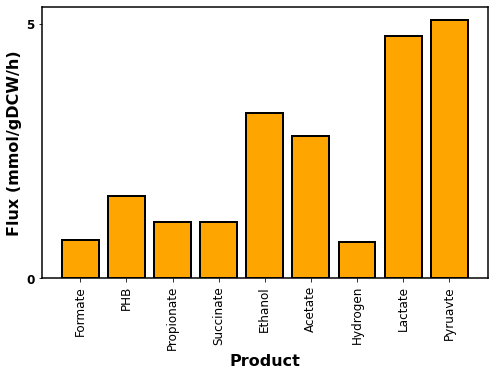

In [197]:
# Create figure showing the minimum and maximum
x = ['Formate', 'PHB', 'Propionate', 'Succinate', 'Ethanol', 'Acetate', 'Hydrogen', 'Lactate', 'Pyruavte']
y = list(prods.values())
fig, ax = plt.subplots(figsize=(8,5))   
plt.bar(x, y,  edgecolor='black', linewidth = 2.0, color = 'orange')
plt.xticks(rotation = 90, size = 12, fontweight = 'normal')
plt.yticks( size = 12)
plt.xlabel('Product', fontweight = 'bold', size = 16)
plt.ylabel('Flux (mmol/gDCW/h)', fontweight = 'bold', size = 16)
plt.setp(ax.spines.values(), linewidth=1.5)
plt.savefig('Figure3_ProductYields.eps', type = 'eps', bbox_inches = 'tight')



### Carry out flux sampling

#### Growth-phase flux sampling

In [ ]:
# Use the same constraints used later for the m_f16 and m_f26 iMAT condition-specific models for comparisons

m_fru = m           
m_fru.reactions.EX_BETA_D_FRUCTOSE_e.bounds = (-2.1, -2.1) # extracted from [ref] see GrowthModelFitting.ipynb
m_fru.reactions.R_FRUPTS.bounds = (0.0, 0.0) # previous study found the ABC is the active reaction [ref]
m_fru.objective = 'R_Biomass'
m_fru.reactions.EX_OXYGEN_MOLECULE_e.bounds = (-5.0, 1000.0) # constrain oxygen to reduce solution space to values close to the optimal growth phase predicted value

# carry out FVA first to constrain model before flux sampling - pfactor of 1.2 prevents unrealistic cycles
res_fru = flux_variability_analysis(m_fru, fraction_of_optimum = 0.9, reaction_list=m_fru.reactions, processes = 6, pfba_factor = 1.2)

# constrain model by the FVA results
for i in m_fru.reactions:
    i.lower_bound = res_fru['minimum'][i.id]-0.00000001
    i.upper_bound = res_fru['maximum'][i.id]+0.00000001




In [ ]:
s1_fru = sample(m_fru, 10000, thinning = 1000, processes=6, seed = 1)
s2_fru = sample(m_fru, 10000, thinning = 1000, processes=6)




#### Nitrogen limited flux sampling

In [ ]:
m = cobra.io.read_sbml_model('../Model/iCN1361.xml')
m_nh4 = m           
m_nh4.reactions.EX_BETA_D_FRUCTOSE_e.bounds = (-2.1, -2.1) # extracted from [ref] see GrowthModelFitting.ipynb
m_nh4.reactions.R_FRUPTS.bounds = (0.0, 0.0) # previous study found the ABC is the active reaction [ref]
m_nh4.objective = 'R_Biomass'
m_nh4.reactions.EX_AMMONIUM_e.bounds = (-0.1, 1000.0)
m_nh4.reactions.R_Biomass.bounds = (0.009, 1000.0)
m_nh4.reactions.EX_OXYGEN_MOLECULE_e.bounds = (-5.0, 1000.0)

# carry out FVA first to constrain model before flux sampling - pfactor of 1.2 prevents unrealistic cycles
res_nh4 = flux_variability_analysis(m_nh4, fraction_of_optimum = 0.9, reaction_list=m_nh4.reactions, processes = 6, pfba_factor = 1.2)

# constrain model by the FVA results
for i in m_nh4.reactions:
    i.lower_bound = res_nh4['minimum'][i.id]-0.00000001
    i.upper_bound = res_nh4['maximum'][i.id]+0.00000001

    
  

In [ ]:
s1_nh4 = sample(m_nh4, 10000, thinning = 1000, processes=6, seed = 1)
s2_nh4 = sample(m_nh4, 10000, thinning = 1000, processes=6)



#### Check if the reaction distributions are the the same across different runs (Converged)

In [200]:
# exclude any reactions that do not have equivalent flux distributions in repeated runs of the sampling - note that this result could change due to comparing to a different sampling for 's2'

import scipy
reacs_exclude = []
for i in m_fru.reactions:
    s_rounded = [round(num, 6) for num in s1_fru[i.id]]
    if len(set(s_rounded)) > 1:
        [ks, p_val] = scipy.stats.ks_2samp(s1_fru[i.id], s2_fru[i.id], alternative='two-sided', mode='auto')
        if p_val < 0.01:
            #print(i.id, ks, p_val)
            reacs_exclude.append(i.id)
print('')
for i in m_nh4.reactions:
    s_rounded = [round(num, 6) for num in s1_nh4[i.id]]
    if len(set(s_rounded)) > 1:
        [ks, p_val] = scipy.stats.ks_2samp(s1_nh4[i.id], s2_nh4[i.id], alternative='two-sided', mode='auto')
        if p_val < 0.01:
            #print(i.id, ks, p_val)
            reacs_exclude.append(i.id)
            
            



505


In [201]:
print('Number of reactions excluded (not converged in the sampling): ', len(reacs_exclude))

Number of reactions excluded (not converged in the sampling):  505


## Integration of gene expression data using iMAT

### compute the reaction expression values

#### Calculate the reaction expression

In [6]:


def map_exp_to_reacs(m, gene_express, condition = 'f16', unconstrained_reacs = []):
    
    reac_expression = {}
    reacs_low_expression = []
    for r in m.reactions:
        if r.id not in unconstrained_reacs:

            # get a list of 'or' genes that includes 'and' genes in internal list
            genes = r.gene_reaction_rule.split('or')
            genes_or = []
            for g in genes:
                gene = g.replace(' ', '').replace('(', '').replace(')', '')
                genes_or.append(gene.split('and'))


            # loop through genes - get the sum of expression of the 'or' genes
            exp_max = 0.0
            for g in genes_or:

                # get minimum
                min_gene_and = 0.0
                if g[0] in list(gene_express['gene']):
                    for ind, gene_tag in enumerate(gene_express['gene']):
                        if gene_tag == g[0]:
                            min_gene_and = gene_express[condition][ind] # if not in the list then leave as preset zero


                # if more than one gene in list ('and' relationship)  
                if len(g) > 1:
                    for gi in g[1:]: # loop through rest of genes in 'and' list and check if in the proteomics data
                        if gi in list(gene_express['gene']):
                            for ind, gene_tag in enumerate(gene_express['gene']):
                                if gene_tag == gi:
                                    if gene_express[condition][ind] < min_gene_and: # if less than value already set then re-value
                                        min_gene_and = gene_express[condition][ind]

                exp_max += min_gene_and # add to the 'or' expression 
                
                # store expression for each reaction
                reac_expression[r.id] = exp_max
        else:
            reac_expression[r.id] = -1
                

                
                
    
    return reac_expression
                


        
                    
        
    
    

    

In [7]:
# load in the expression data
gene_express = pd.read_excel('Data/gene_exp_fructose.xlsx')
# exclude transport and spontaneous reactions
unconstrained_reacs = ['R_ATPM', 'R_Biomass']
for r in m.reactions:
    if 'EX_' in r.id:
        unconstrained_reacs.append(r.id)
    if r.gene_reaction_rule == 'Spontaneous':
        unconstrained_reacs.append(r.id)
    if r.gene_reaction_rule == '':
        unconstrained_reacs.append(r.id)
        
RPKM_f16 = map_exp_to_reacs(m, gene_express, condition = 'f16', unconstrained_reacs = unconstrained_reacs)
RPKM_f26 = map_exp_to_reacs(m, gene_express, condition = 'f26', unconstrained_reacs = unconstrained_reacs)




# for the nitrogen limited conditions use the RPKM x the fold change from the growth phase (i.e. large changes will have a high weighting and high expression will have a high weight)
RPKM_foldchanges = {}
for i, j in RPKM_f16.items():
    if j != -1:
        RPKM_foldchanges[i] = ((RPKM_f26[i]+1)/(j+1))
    else:
        RPKM_foldchanges[i] = -1
        
exp_f26 = {}
for i, j in RPKM_f26.items():
    if j != -1:
        e = j*RPKM_foldchanges[i]
        exp_f26[i] = e
    else:
        exp_f26[i] = -1

### get the lower threshold for the iMAT algorithm

In [8]:
with open('Data/Cnec_essential_reactions.json', 'r') as fn:
    essential_reacs = json.load(fn)
    
# cutoff determination
essential_exp_f16 = {}
for i in essential_reacs:
    if RPKM_f16[i] != -1:
        essential_exp_f16[i] = RPKM_f16[i]
        
ess_exp_f16 = []
for i, j in essential_exp_f16.items():
    if j < 212.0:
        print(i, j)
        ess_exp_f16.append(j)

R_DIHYDRODIPICSYN_RXN 47.0
R_DEPHOSPHOCOAKIN_RXN 0.0


In [83]:
essential_exp_f26 = {}
for i in essential_reacs:
    if exp_f26[i] != -1:
        essential_exp_f26[i] = exp_f26[i]

ess_exp_f26 = []
for i, j in essential_exp_f26.items():
    if j < 21.0:
        print(i, j)
        ess_exp_f26.append(j)
        

R_DEPHOSPHOCOAKIN_RXN 0.0
R_FRUCTOKINASE_RXN 5.232072617246597


### get the upper threshold for the iMAT algorithm

In [84]:
exp_vals_f16 = []
for i, j in RPKM_f16.items():
    if i != -1:
        exp_vals_f16.append(j)
print('95th percentilte of f16 RPKM values: ', np.quantile(exp_vals_f16, 0.95))


95th percentilte of f16 RPKM values:  11439.0


In [85]:
exp_vals_f26 = []
for i, j in exp_f26.items():
    if j != -1:
        exp_vals_f26.append(j)
print('95th percentilte of f26 RPKM*foldchange: ', np.quantile(exp_vals_f26, 0.95))


95th percentilte of f26 RPKM*foldchange:  17535.336296296296


In [291]:
df_RPKM = pd.DataFrame(index = list(exp_f26.keys()))
reacexp_f16 = []
reacexp_f26 = []
for i in exp_f26.keys():
    reacexp_f16.append(RPKM_f16[i])
    reacexp_f26.append(exp_f26[i])
    
df_RPKM.insert(0, column = 'Reac expression F16', value = reacexp_f16)
df_RPKM.insert(1, column = 'Reac expression F26 * foldchange', value = reacexp_f26)

df_RPKM.to_excel('../MatlabCode/CnecatorH16_ReactionExpression.xlsx')


### Please see Matlab script for running iMAT simulation

#### Load in iMAT models

In [9]:
m_f16 = cobra.io.read_sbml_model('Data/iCN1361_f16.xml')
m_f26 = cobra.io.read_sbml_model('Data/iCN1361_f26.xml')



### Run FVA to constrain modelling before running sampling

In [101]:

m_f26.reactions.EX_OXYGEN_MOLECULE_e.bounds = (-5.0, 1000.0) # constrain to level found in optimal fructose growth phase so that extra oxygen isn't allowed, to constrain the solution space
m_f16.reactions.EX_OXYGEN_MOLECULE_e.bounds = (-5.0, 1000.0)


# carry out FVA first to constrain model before flux sampling - pfactor of 1.2 prevents unrealistic cycles
res_f16 = flux_variability_analysis(m_f16, fraction_of_optimum = 0.9, reaction_list=m_f16.reactions, processes = 6, pfba_factor = 1.2)
res_f26 = flux_variability_analysis(m_f26, fraction_of_optimum = 0.9, reaction_list = m_f26.reactions, processes = 6, pfba_factor=1.2) 

# constrain model by the FVA results
for i in m_f16.reactions:
    i.lower_bound = res_f16['minimum'][i.id]-0.00000001
    i.upper_bound = res_f16['maximum'][i.id]+0.00000001
    
for i in m_f26.reactions:
    i.lower_bound = res_f26['minimum'][i.id]-0.00000001
    i.upper_bound = res_f26['maximum'][i.id]+0.00000001

### Flux sampling

#### run on F16 iMAT model

In [102]:
s1_f16 = sample(m_f16, 10000, thinning = 1000, processes=6, seed = 1)
s2_f16 = sample(m_f16, 10000, thinning = 1000, processes=6)


Read LP format model from file /var/folders/3x/_g2glqss339cz4n4dwyrcbxh0000gn/T/tmp1oewd3eh.lp
Reading time = 0.01 seconds
: 477 rows, 946 columns, 4440 nonzeros
Read LP format model from file /var/folders/3x/_g2glqss339cz4n4dwyrcbxh0000gn/T/tmpkfxeag3e.lp
Reading time = 0.01 seconds
: 477 rows, 946 columns, 4440 nonzeros


In [103]:
import scipy
reacs_exclude = []
for i in m_f16.reactions:
    s_rounded = [round(num, 6) for num in s1_f16[i.id]]
    if len(set(s_rounded)) > 1:
        [ks, p_val] = scipy.stats.ks_2samp(s1_f16[i.id], s2_f16[i.id], alternative='two-sided', mode='auto')
        if p_val < 0.01:
            print(i.id, ks, p_val)
            reacs_exclude.append(i.id)

RXN_10462_C16 0.024895020995800876 0.003994283365681688
CDPDIGLYSYN_RXN_C16 0.025794841031793636 0.00252930640475385
1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN_C16 0.024895020995800876 0.003994283365681688


#### run on F26 iMAT model

In [104]:
s1_f26_PHB = sample(m_f26, 10000, thinning = 1000, processes=6, seed = 1)
s2_f26_PHB = sample(m_f26, 10000, thinning = 1000, processes=6)


Read LP format model from file /var/folders/3x/_g2glqss339cz4n4dwyrcbxh0000gn/T/tmpsouljxop.lp
Reading time = 0.01 seconds
: 501 rows, 1008 columns, 4690 nonzeros
Read LP format model from file /var/folders/3x/_g2glqss339cz4n4dwyrcbxh0000gn/T/tmph4dsvy2a.lp
Reading time = 0.01 seconds
: 501 rows, 1008 columns, 4690 nonzeros


### Check that running the flux sampling leads to equivalent distributions...

In [105]:
# exclude any reactions that do not have equivalent flux distributions in repeated runs of the sampling - note that this result could change due to comparing to a different sampling for 's2'

import scipy
reacs_exclude = []
for i in m_f16.reactions:
    s_rounded = [round(num, 6) for num in s1_f16[i.id]]
    if len(set(s_rounded)) > 1:
        [ks, p_val] = scipy.stats.ks_2samp(s1_f16[i.id], s2_f16[i.id], alternative='two-sided', mode='auto')
        if p_val < 0.01:
            print(i.id, ks, p_val)
            reacs_exclude.append(i.id)
print('')
for i in m_f26.reactions:
    s_rounded = [round(num, 6) for num in s1_f26_PHB[i.id]]
    if len(set(s_rounded)) > 1:
        [ks, p_val] = scipy.stats.ks_2samp(s1_f26_PHB[i.id], s2_f26_PHB[i.id], alternative='two-sided', mode='auto')
        if p_val < 0.01:
            print(i.id, ks, p_val)
            reacs_exclude.append(i.id)
            

RXN_10462_C16 0.024895020995800876 0.003994283365681688
CDPDIGLYSYN_RXN_C16 0.025794841031793636 0.00252930640475385
1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN_C16 0.024895020995800876 0.003994283365681688



### Reactions associated with the fixed growth rate

Reactions that show little variation across all 10000 samples in both the f16 and f26 models are likely correlated to the fixed growth rate. To identify such reactions, we searched for reactions whose flux value had a standard deviation of less than 0.001 across the 10000 samples in both models. 

In [108]:
# Get the reactions that are constant - are they the same between models?
reacs_growth_down = []
reacs_growth_up = []
FC = {}
for i in m_f26.reactions:
    if i in m_f16.reactions:
        if np.std(s1_f16[i.id]) < 0.001 and np.std(s1_f26_PHB[i.id]) < 0.001:
            if 'EX_' not in i.id:
                if 'R_FRUABC' not in i.id:
                    if 'dummy' not in i.id:
                        if (np.mean(s1_f26_PHB[i.id]) - np.mean(s1_f16[i.id]))/(np.mean(s1_f26_PHB[i.id]) + np.mean(s1_f16[i.id])) > 0.36:
                            
                            reacs_growth_up.append(i.id)
                            FC[i.id] = (np.mean(s1_f26_PHB[i.id]) - np.mean(s1_f16[i.id]))/(np.mean(s1_f26_PHB[i.id]) + np.mean(s1_f16[i.id]))
                            
                            
                        if (np.mean(s1_f26_PHB[i.id]) - np.mean(s1_f16[i.id]))/(np.mean(s1_f26_PHB[i.id]) + np.mean(s1_f16[i.id])) < -0.36:
                            
                            reacs_growth_down.append(i.id)
                            FC[i.id] = (np.mean(s1_f26_PHB[i.id]) - np.mean(s1_f16[i.id]))/(np.mean(s1_f26_PHB[i.id]) + np.mean(s1_f16[i.id]))
                            

In [109]:
print('Reactions down regulated due to growth: ', len(reacs_growth_down))


Reactions down regulated due to growth:  390


In [617]:
#df = pd.read_excel('../SupplementaryFiles/SupplementaryFile5_NitrogenLimitation.xlsx', sheet_name='Table S13')

### Differentially altered reactions

Next, we identified the reactions whose flux was able to vary (i.e. was able to vary with fixed growth rate). To this aim, we used the Kruskal-Wallis (KS) test to identify reactions whose flux distribution was significantly different (p < 0.05) between the sampling on each conditional-model. Benjamini-Hochberg multiple testing correction was applied. 

In [110]:
# get the reactions that have sig. different distributions between two conditions

altered_reactions = {}
non_altered_reactions = {}
for i in m_f16.reactions:
    if i.id not in reacs_growth_down:
        if i in m_f26.reactions:
            [ks, p_val] = scipy.stats.ks_2samp(s1_f16[i.id], s1_f26_PHB[i.id], alternative='two-sided', mode='auto')
            if p_val < 0.05:
                if i.id not in reacs_exclude:
                    altered_reactions[i.id] = p_val
            else:
                non_altered_reactions[i.id] = p_val
                
                
for i in m_f26.reactions:
    if i.id not in reacs_growth_down:
        if i in m_f16.reactions:
            [ks, p_val] = scipy.stats.ks_2samp(s1_f26_PHB[i.id], s1_f16[i.id], alternative='two-sided', mode='auto')
            if p_val < 0.05:
                if i.id not in reacs_exclude:
                    altered_reactions[i.id] = p_val
            else:
                non_altered_reactions[i.id] = p_val

pvals = list(altered_reactions.values())
### Multiple testing correction - Benjamini-Hochberg FDR
pvals_adjusted = multipletests(pvals, alpha = 0.05, method = 'fdr_bh')

                

### Differentially altered reactions exclusive to each model 

To test whether reactions exclusive to one model (i.e. in the f16 iMAT model but not the f26 iMAT model, or vice versa) were significantly altered, we used bootstrapping, as described in [ref], using a significance of p < 0.05. 

In [111]:
# Get the altered reactions which are exclusive to one model - use bootstrapping

for i in m_f26.reactions:
    if i not in m_f16.reactions:
        #print(i.id)
        Replications = np.array([np.random.choice(s1_f26_PHB[i.id], len(s1_f26_PHB[i.id]), replace = True) for _ in range(1000)])
        Mean = np.mean(Replications, axis=1)
        #print(np.mean(Mean) - 1.96*np.std(Mean), np.mean(Mean) + 1.96*np.std(Mean))
        if np.mean(Mean) - 1.96*np.std(Mean) < 0 and np.mean(Mean) + 1.96*np.std(Mean) > 0:
            print(i.id, 'Zero is included')
        else:
            if i.id not in reacs_exclude:
                altered_reactions[i.id] = 0.05
            

for i in m_f16.reactions:
    if i not in m_f26.reactions:
        Replications = np.array([np.random.choice(s1_f16[i.id], len(s1_f16[i.id]), replace = True) for _ in range(1000)])
        Mean = np.mean(Replications, axis=1)
        if np.mean(Mean) - 1.96*np.std(Mean) < 0 and np.mean(Mean) + 1.96*np.std(Mean) > 0:
            print(i.id, 'Zero is included')
        else:
            if i.id not in reacs_exclude:
                altered_reactions[i.id] = 0.05
            
     
        



In [112]:
### Calculate the fold changes of altered reactions
count = 0
for r in altered_reactions.keys():
    if r in m_f16.reactions and r in m_f26.reactions:
        FC[r] = (np.mean(s1_f26_PHB[r]) - np.mean(s1_f16[r]))/(np.mean(s1_f26_PHB[r]) + np.mean(s1_f16[r]))
        count += 1
    
    if r in m_f16.reactions and r not in m_f26.reactions:
        FC[r] = -1
        count += 1
    
    if r in m_f26.reactions and r not in m_f16.reactions:
        FC[r] = 1
        count += 1
print(count)



134


### Calculate the fold changes

A second criteria using the fold changes was applied to select the most significantly altered reactions. 

In [113]:
### Calculate the fold changes of altered reactions
count = 0
for r in altered_reactions.keys():
    if r in m_f16.reactions and r in m_f26.reactions:
        FC[r] = (np.mean(s1_f26_PHB[r]) - np.mean(s1_f16[r]))/(np.mean(s1_f26_PHB[r]) + np.mean(s1_f16[r]))
        count += 1
    
    if r in m_f16.reactions and r not in m_f26.reactions:
        FC[r] = -1
        count += 1
    
    if r in m_f26.reactions and r not in m_f16.reactions:
        FC[r] = 1
        count += 1
print(count)


134


### Collect the up-regulated and down-regulated reactions

Select the reactions who are significantly altered by their flux distributions and whose fold change is greater than 0.82 (corresponds to a 10-fold change in flux), as used in [ref]. 

In [114]:
down_reg_reacs = []
up_reg_reacs = []
for i, j in FC.items():
    if j > 0.33:
        if abs(np.mean(s1_f26_PHB[i])) > 0.0001: # only include those with mean flux above 0.0001 
            up_reg_reacs.append(i)
    elif j < -0.33:
        if abs(np.mean(s1_f16[i])) > 0.0001: # only include those with mean flux above 0.0001 
            down_reg_reacs.append(i)
        
        

In [115]:
print('Number of reactions down-regulated: ', len(down_reg_reacs))

Number of reactions down-regulated:  396


In [116]:
print('Number of reactions up-regulated: ', len(up_reg_reacs))

Number of reactions up-regulated:  66


### Genterate Figure 4

In [10]:
# load in the defined metabolic systems and subsystems (as defined by kegg) 
with open('Data/m_systems.json', 'r') as fn:
    systems = json.load(fn)
    
with open('Data/m_subsystems.json', 'r') as fn:
    subsystems = json.load(fn)
    
    

In [131]:
len(down_reg_reacs)

396

/opt/anaconda2/envs/pyTFA_2/lib/python3.7/site-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no longer supported as of 3.3 and will become an error two minor releases later
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


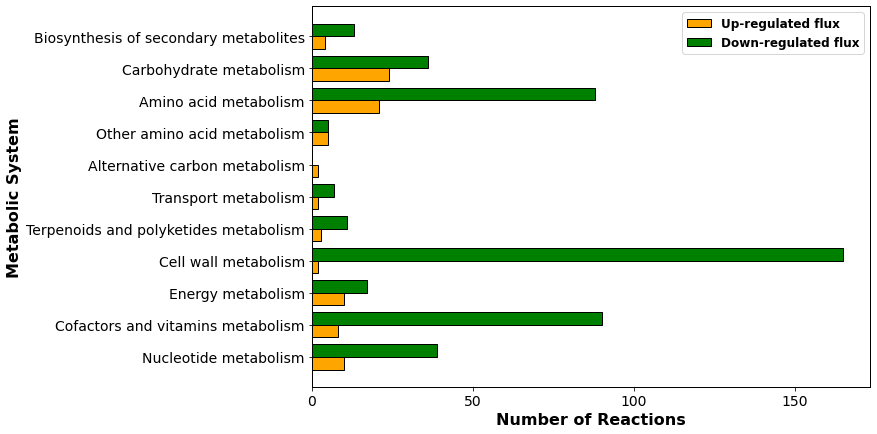

In [198]:
import matplotlib.ticker as ticker
x = []
for i, j in systems.items():
    for k in j:
        x.append(k)
x = list(set(x))

y_up = []
y_down = []
for s in x:
    freq_up = 0
    for r in up_reg_reacs:
        if 'EX_' not in r:
            name = 'R_' + r
        else:
            name = r
        if name in systems:
            if s in systems[name]:
                freq_up += 1
    y_up.append(freq_up)
    
    freq_down = 0
    for r in down_reg_reacs:
        if 'EX_' not in r:
            name = 'R_' + r
        else:
            name = r
        if name in systems:
            if s in systems[name]:
                freq_down += 1
    y_down.append(freq_down)
    
r1 = np.arange(len(x))
barWidth = 0.4
r2 = [x + barWidth for x in r1]


fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(111)
#plt.barh(y_up, r1, color='orange', linewidth = 2.0, width=barWidth, edgecolor='black', label='Up-regulated flux')
#plt.barh(y_down,r2, color='green', linewidth = 2.0, width=barWidth, edgecolor='black', label='Down-regulated flux')
plt.barh(r1, y_up, color='orange', height=barWidth, edgecolor='black', label='Up-regulated flux')
plt.barh(r2, y_down, color='green', height= barWidth, edgecolor='black', label='Down-regulated flux')
plt.ylabel('Metabolic System', fontweight='bold', size = 16)
plt.xlabel('Number of Reactions', fontweight = 'bold', size = 16)
plt.yticks([r + barWidth/2 for r in range(len(y_up))], x)
plt.yticks(size = 14, fontweight = 'normal')
plt.xticks(size = 14, fontweight = 'normal')
plt.legend(loc = 'best', prop = {'size' : 12})
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.0)


plt.savefig('Figure4_AlteredReactions.eps', type = 'eps', bbox_inches = 'tight')


### Figure 5 - Plot the mean flux values for central carbon metabolism

load in the data that maps the reaction to the ID in the diagram

In [12]:
reac_mappings = pd.read_excel('Data/ReactionName_mappings.xlsx', sheet_name='Sheet2')


In [122]:
reac_index = {}
reac_titles = {}
for ind, r in enumerate(reac_mappings['Reaction']):
    if 'R_' in r:
        r = r[2:]
    reac_index[r] = reac_mappings['Index'][ind]
    reac_titles[r] = reac_mappings['Abbreviation'][ind]
    

/opt/anaconda2/envs/pyTFA_2/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


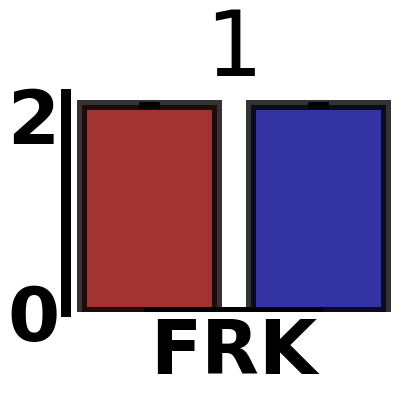

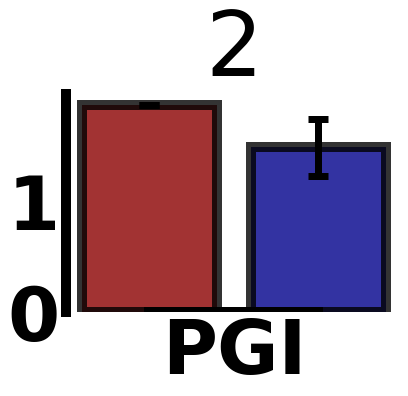

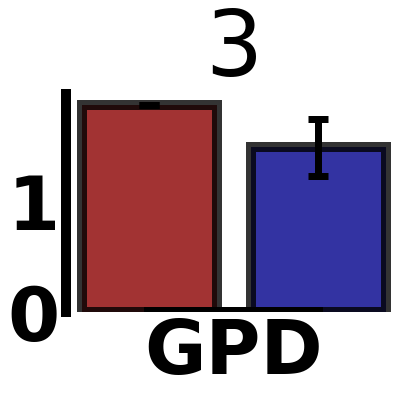

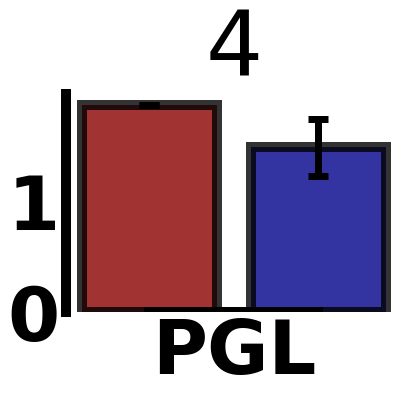

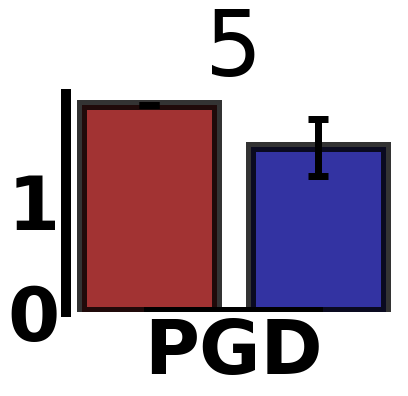

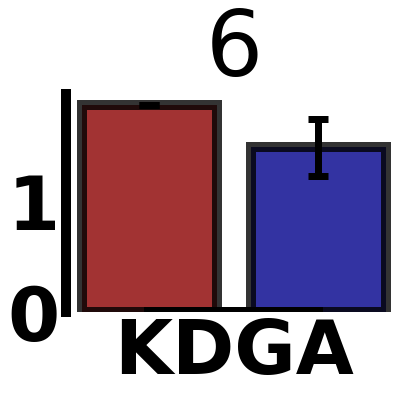

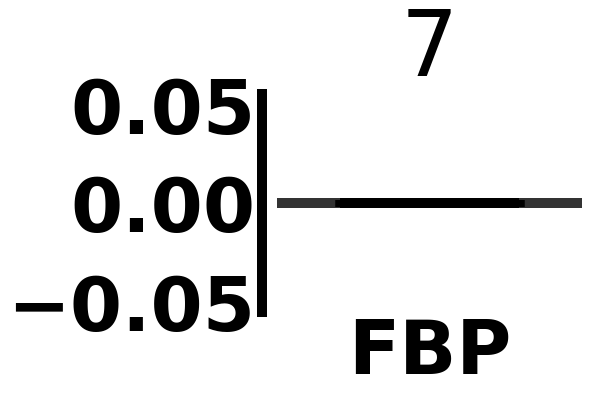

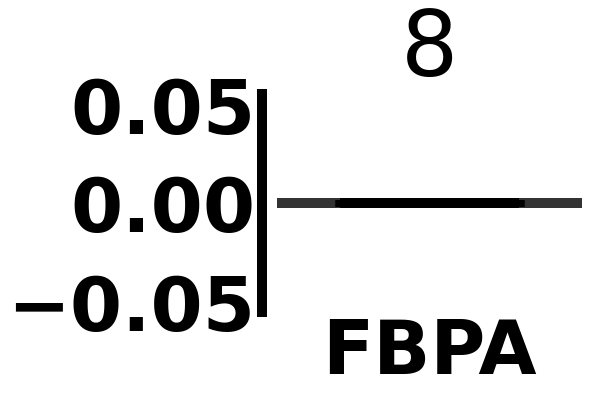

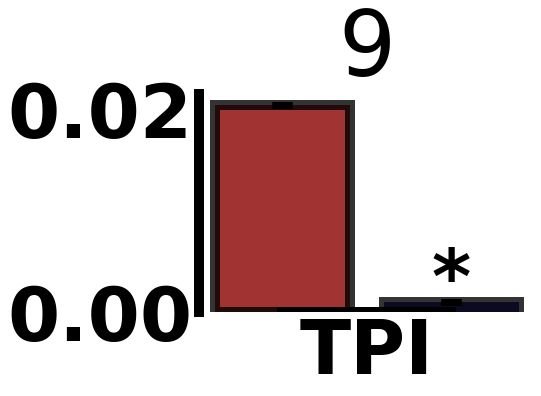

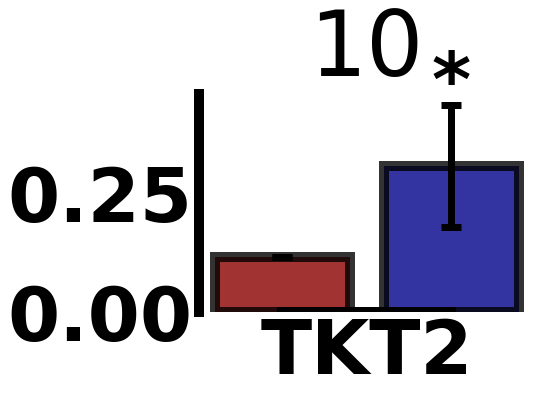

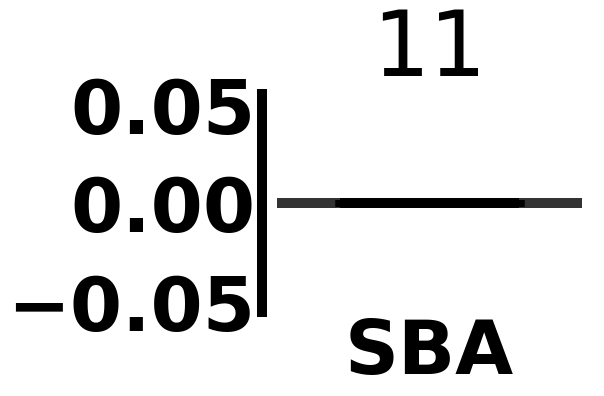

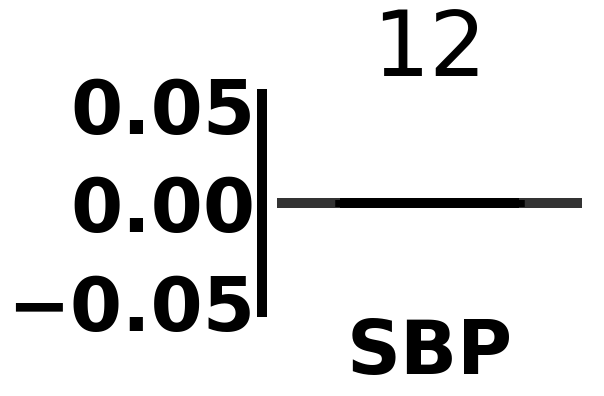

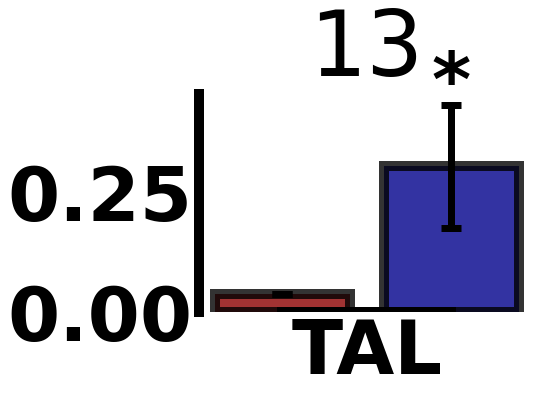

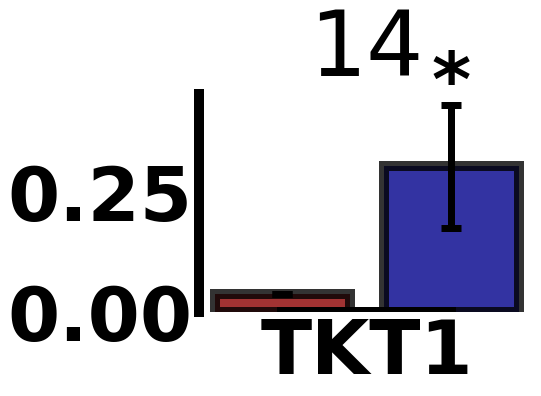

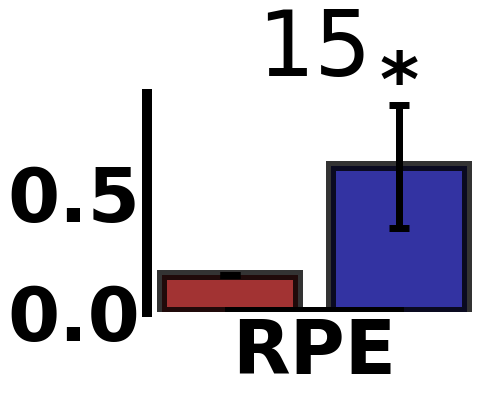

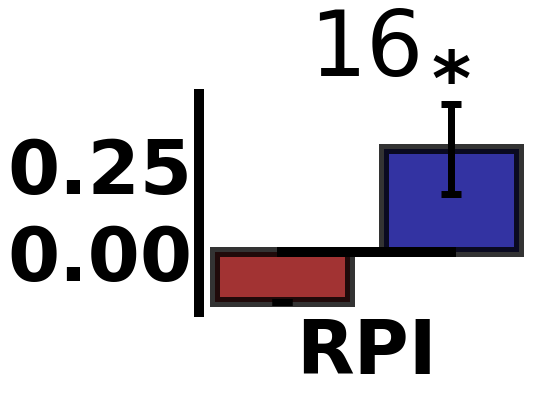

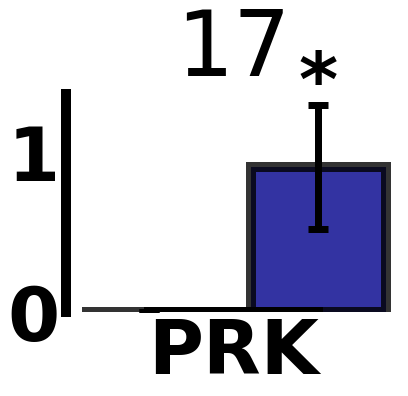

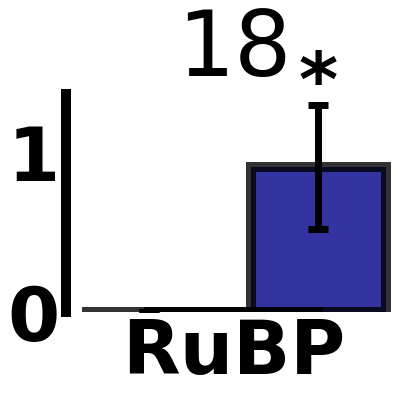

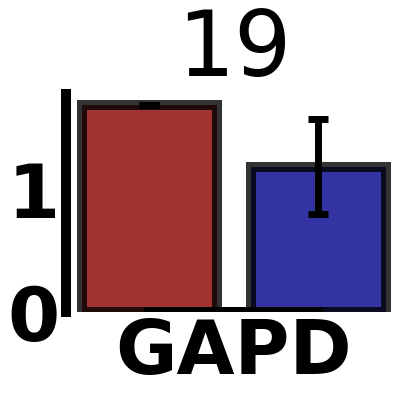

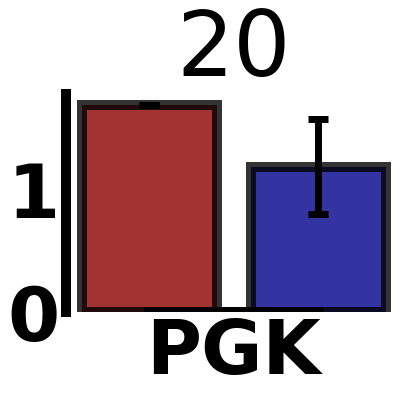

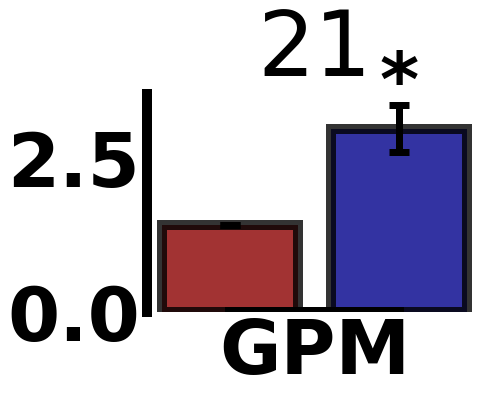

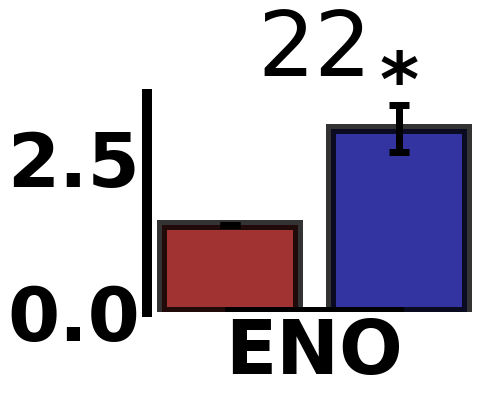

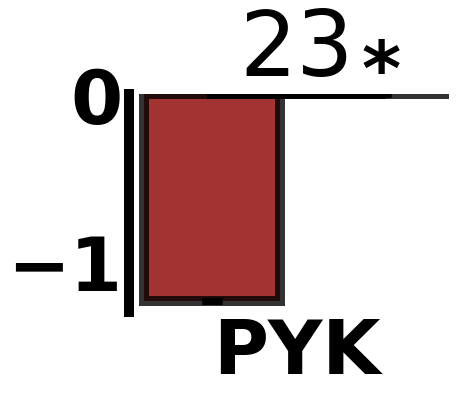

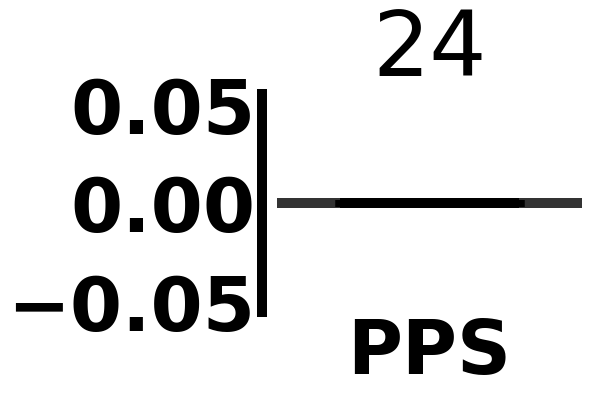

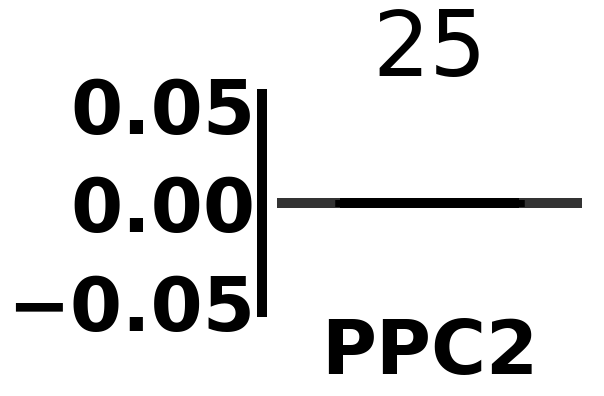

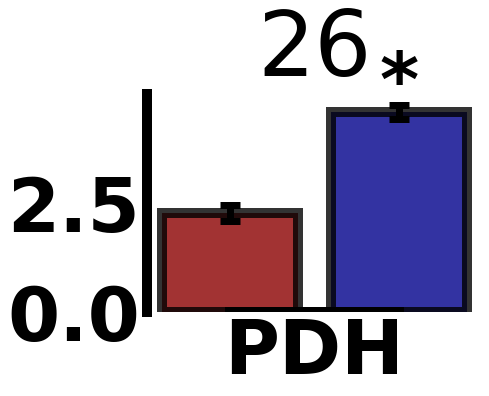

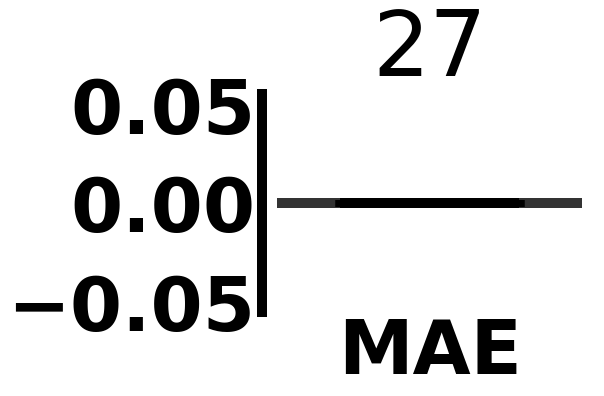

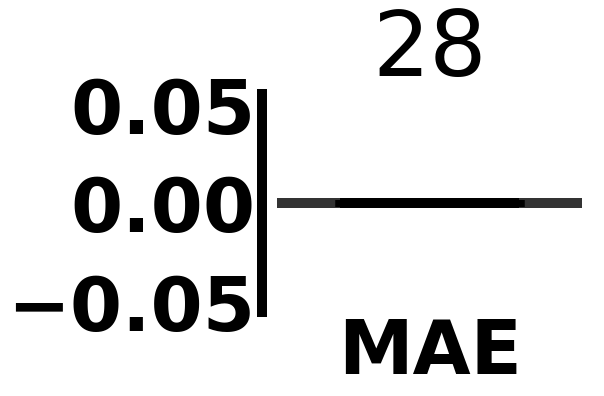

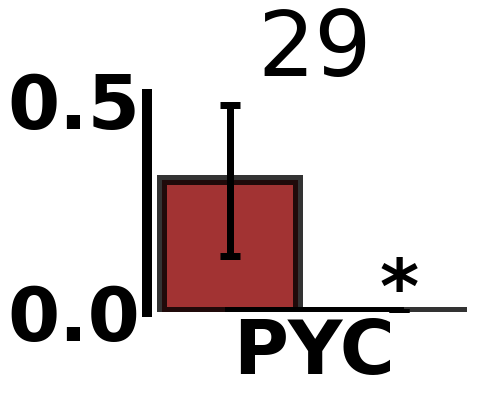

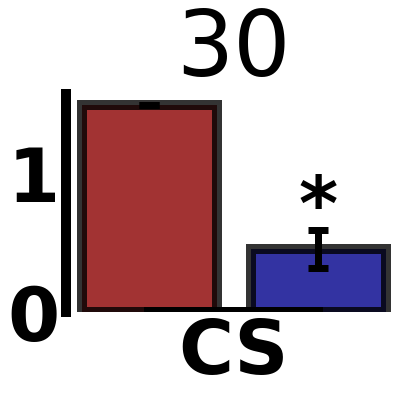

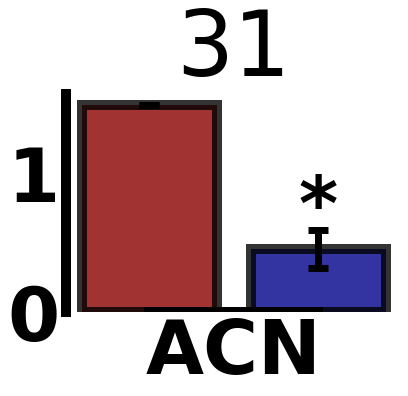

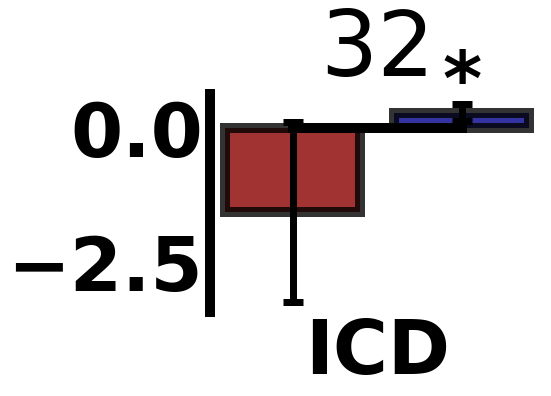

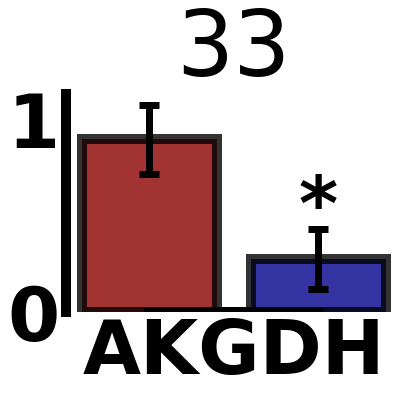

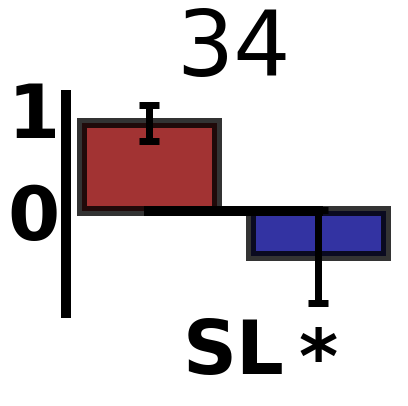

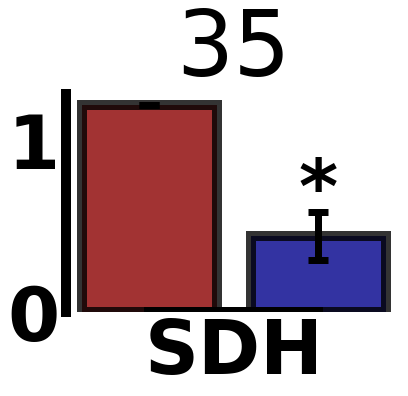

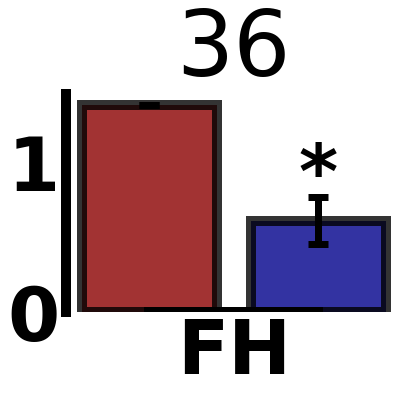

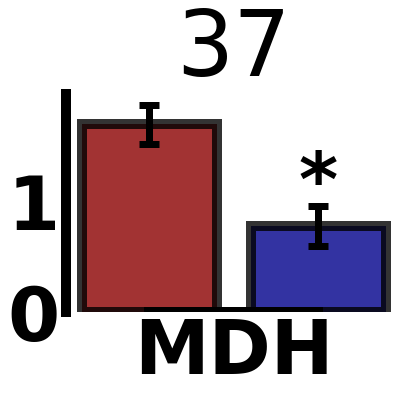

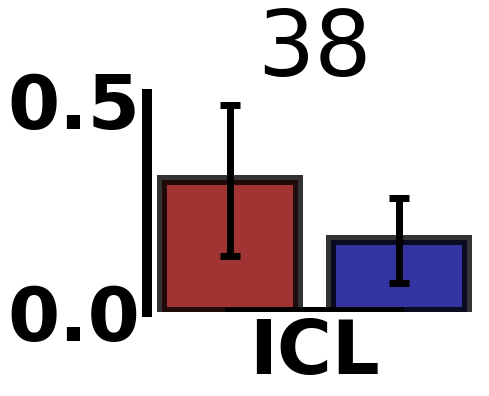

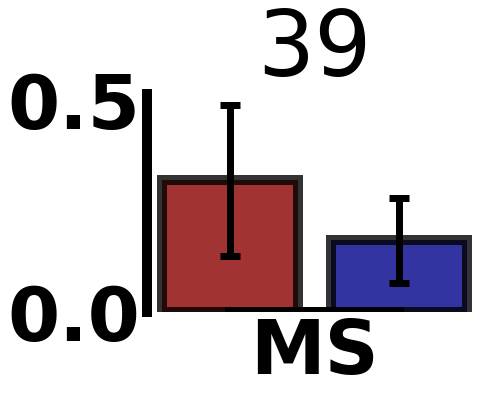

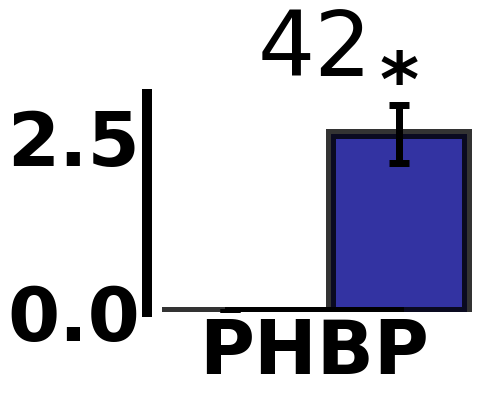

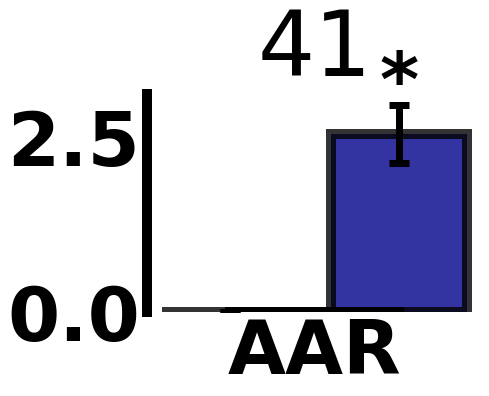

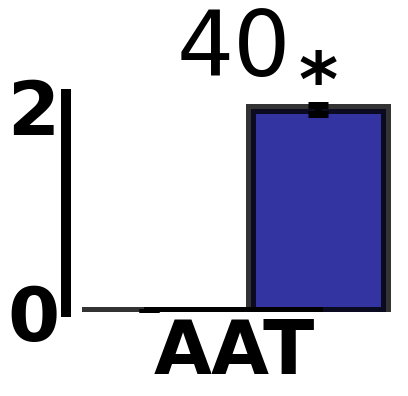

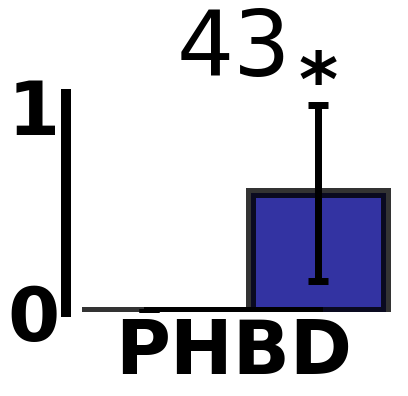

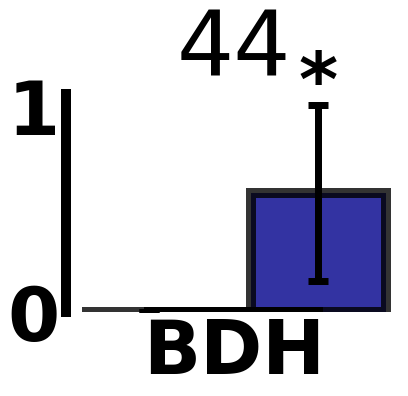

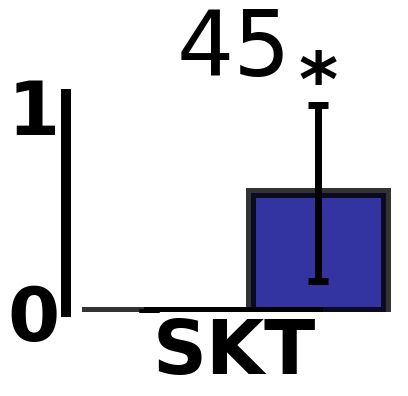

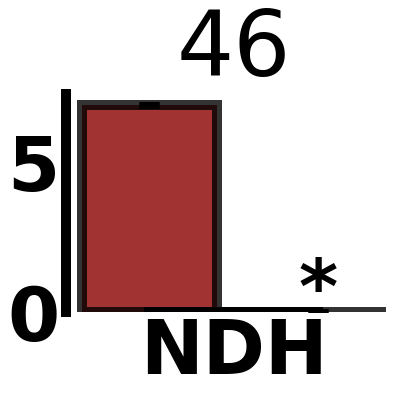

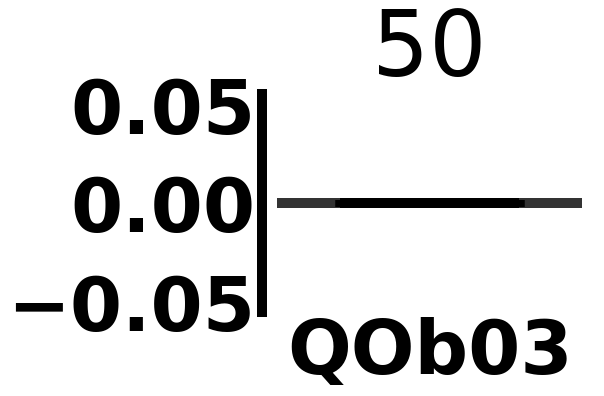

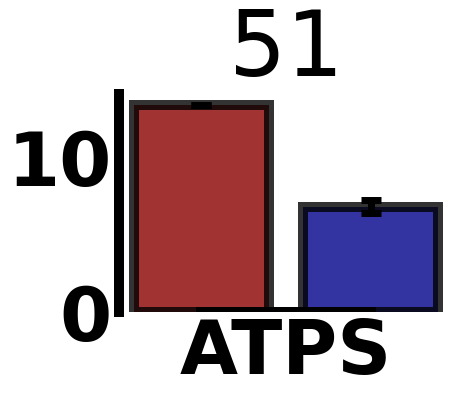

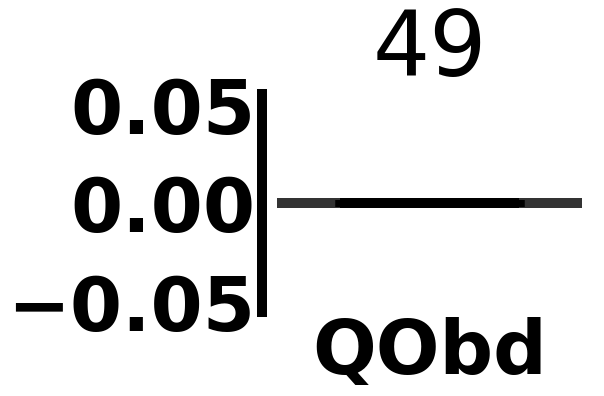

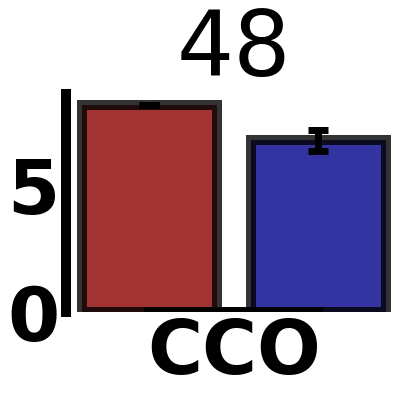

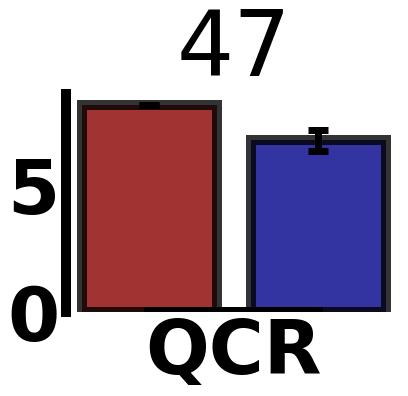

In [127]:
# plot the barcharts - sort the directions out for some of the reactions

# chnage the direction of reactions whose flux in the model goes in the opposite direction to the diagram
directions1 = ['PGLUCISOM_RXN', 'PEPCARBOX_RXN', 'FUMHYDR_RXN', 'TRANSALDOL_RXN', 'RIBULP3EPIM_RXN', '2TRANSKETO_RXN', '3PGAREARR_RXN', 'RXN_5901']
directions2 = ['PGLUCISOM_RXN', 'PEPCARBOX_RXN', 'FUMHYDR_RXN', 'RXN_5901', 'TRANSALDOL_RXN', 'RIBULP3EPIM_RXN', '2TRANSKETO_RXN', 'RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN', '3PGAREARR_RXN']
switch = ['PHOSGLYPHOS_RXN', 'RXN0_1133', 'SUCCCOASYN_RXN']

# plot the fluxes of each condition on the plot

x = np.arange(2)  # the label locations

# folder to save files to
folder_name = '../../../barcharts_iMAT/'
cit = 0
for r, indr in reac_index.items():

    if r in reac_titles:

        if r not in m_f16.reactions and r not in m_f26.reactions:
            y = [0, 0]
            std = [0, 0]

        elif r not in m_f16.reactions and r in m_f26.reactions:
            if r in directions2:
                y = [0, abs(np.mean(s1_f26_PHB[r]))]                
            else:
                y = [0, abs(np.mean(s1_f26_PHB[r]))]
            std = [0, np.std(s1_f26_PHB[r])]

        elif r in m_f16.reactions and r not in m_f26.reactions:
            if r in directions1:
                y = [abs(np.mean(s1_f16[r])), 0]
            else:
                y = [np.mean(s1_f16[r]), 0]
            std = [np.std(s1_f16[r]), 0]

        else:
            if r in directions1 and r in directions2:
                y = [abs(np.mean(s1_f16[r])), abs(np.mean(s1_f26_PHB[r]))]
            elif r in directions1:
                y = [abs(np.mean(s1_f16[r])), np.mean(s1_f26_PHB[r])]
            elif r in directions2:
                y = [np.mean(s1_f16[r]), abs(np.mean(s1_f26_PHB[r]))]
            elif r in switch:
                y = [-1*np.mean(s1_f16[r]), -1*np.mean(s1_f26_PHB[r])]
            else:
                y = [np.mean(s1_f16[r]), np.mean(s1_f26_PHB[r])]
            std = [np.std(s1_f16[r]), np.std(s1_f26_PHB[r])]



        ax = plt.figure()
        plt.rc('axes', linewidth = 6.0)
        barlist = plt.bar(x, y, yerr=std, align='center', alpha=0.8, ecolor='black', capsize=10,error_kw=dict(lw=7, capsize=10, capthick=7),  linewidth = 4)
        barlist[0].set_color('darkred')
        barlist[0].set_edgecolor('k')
        barlist[0].set_linewidth(10)
        barlist[1].set_color('darkblue')
        barlist[1].set_edgecolor('k')
        barlist[1].set_linewidth(10)



        font = {'family' : 'bold',
                'weight' : 'bold',
                'size'   : 75}

        plt.rc('font', **font)

        plt.xticks([])
        barlist[0].axes.spines['right'].set_visible(False)
        barlist[0].axes.spines['top'].set_visible(False)
        barlist[0].axes.spines['bottom'].set_visible(False)
        barlist[0].axes.spines['left'].set_color('black')
        barlist[0].axes.spines['left'].set_linewidth(10)
        if r in up_reg_reacs or r in down_reg_reacs:
        
            if y[1] >= 0.0:
                plt.text(0.6+barlist[1].get_width() / 2., barlist[1].get_height()+std[1], '*', ha = 'center')
            if y[1] < 0.0:
                p = barlist[1].get_height()-std[1]               
                plt.text(0.6+barlist[1].get_width() / 2., barlist[1].get_height()-1.5*std[1], '*', ha = 'center', va = 'top')

           
                
        x1 = np.array([0, 1])
        y = np.array([0, 0])
        plt.plot(x1, y, 'k', linewidth = 10)
        plt.xlabel(reac_titles[r], fontweight = 'bold')
        plt.title(indr)


        plt.rc('font', **font)
        plt.savefig(folder_name + str(indr)+ '_' + str(reac_titles[r]) + '.png',  bbox_inches = 'tight')




In [616]:
for i in m.metabolites.M_FRUCTOSE_16_DIPHOSPHATE.reactions:
    print(i.id, i.reaction)

R_F16BDEPHOS_RXN M_FRUCTOSE_16_DIPHOSPHATE + M_WATER --> M_FRUCTOSE_6P + M_Pi
R_F16ALDOLASE_RXN M_FRUCTOSE_16_DIPHOSPHATE <=> M_DIHYDROXY_ACETONE_PHOSPHATE + M_GAP


In [607]:
vals2 = []
for i, j in RPKM_f26.items():
    if j != -1:
        vals2.append(j)

### Correlations of reactions between samples

In [136]:
### Correlations between the samples...

for i in m.reactions:
    reac = i.id[2:]
    if reac in m_f26.reactions:
        #if abs(np.mean(s1_f26[reac])) > 0.05: 
        #    print(i.id, i.reaction, np.mean(s1_f26[reac]))
        #    print('')
        corrcoef = s1_f26_PHB['RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN'].corr(s1_f26_PHB[reac])
        if corrcoef > 0.6:
            print(i.id, i.reaction, corrcoef)
            print('')

R_GLU6PDEHYDROG_RXN M_GLC_6_P + M_NADP <=> M_D_6_P_GLUCONO_DELTA_LACTONE + M_NADPH + M_PROTON 0.9999997879178097

R_GAPOXNPHOSPHN_RXN M_GAP + M_NAD + M_Pi <=> M_DPG + M_NADH + M_PROTON 0.9999996811598996

R_PGLUCONDEHYDRAT_RXN M_CPD_2961 <=> M_2_KETO_3_DEOXY_6_P_GLUCONATE + M_WATER 0.9999997879178097

R_RXN_14192 M_DATP + M_PYRUVATE <-- M_DADP + M_PHOSPHO_ENOL_PYRUVATE + M_PROTON 0.999998684882399

R_TRANSALDOL_RXN M_D_SEDOHEPTULOSE_7_P + M_GAP <=> M_ERYTHROSE_4P + M_FRUCTOSE_6P 0.9999999767916047

R_2TRANSKETO_RXN M_ERYTHROSE_4P + M_XYLULOSE_5_PHOSPHATE <=> M_FRUCTOSE_6P + M_GAP 0.9999997870011272

R_3PGAREARR_RXN M_2_PG <=> M_G3P 0.9999991382087657

R_RIBULP3EPIM_RXN M_RIBULOSE_5P <=> M_XYLULOSE_5_PHOSPHATE 0.999999905793865

R_RXN0_1133 M_ACETYL_COA + M_Pyruvate_dehydrogenase_dihydrolipoate <=> M_CO_A + M_Pyruvate_dehydrogenase_acetylDHlipoyl 0.8043514986272082

R_DADPKIN_RXN M_ATP + M_DADP <=> M_ADP + M_DATP 0.9999986741554128

R_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN 2.0 M_G3P + 2.

### Save results to supplementary excel file

In [160]:
reactions = [r.id for r in m.reactions]
df = pd.DataFrame(index = reactions)


flux_meanf16 = []
flux_stdf16 = []
flux_meanf26 = []
flux_stdf26 = []
sig_diff_flux = []
mean_fold_change = []
pval_altered = []
fold_change_exp = []

for i in m.reactions:
    if 'R_' in i.id:
        reac_id = i.id[2:]
    else:
        reac_id = i.id
    
    if reac_id in reacs_growth_down:
        sig_diff_flux.append('Reduced fixed flux correlated to reduced biomass')
        pval_altered.append(0)
    elif reac_id in altered_reactions:
        if reac_id in m_f16.reactions and reac_id in m_f26.reactions:
            sig_diff_flux.append('Sig. different fluxes')
            pval_altered.append(altered_reactions[reac_id])
        elif reac_id in m_f16.reactions:
            sig_diff_flux.append('Sig. different fluxes (only in f16 model)')
            pval_altered.append(0.05)
        elif reac_id in m_f26.reactions:
            sig_diff_flux.append('Sig. different fluxes (only in f26 model)')
            pval_altered.append(0.05)
    else:
        if reac_id in m_f16.reactions or reac_id in m_f26.reactions:
            sig_diff_flux.append('No sig. difference in flux')
            pval_altered.append('')
        else:
            sig_diff_flux.append('Reaction not in either model')
            pval_altered.append('')
            
            
    if reac_id in m_f16.reactions:
        flux_meanf16.append(np.mean(s1_f16[reac_id]))
        flux_stdf16.append(np.std(s1_f16[reac_id]))
    else:
        flux_meanf16.append('')
        flux_stdf16.append('')
        
        
    if reac_id in m_f26.reactions:
        flux_meanf26.append(np.mean(s1_f26_PHB[reac_id]))
        flux_stdf26.append(np.std(s1_f26_PHB[reac_id]))
    else:
        flux_meanf26.append('')
        flux_stdf26.append('')
        
    if reac_id in FC:
        mean_fold_change.append(FC[reac_id])
    else:
        mean_fold_change.append('')
        
    ### Get the fold change for the gene expression for the reactions
    if RPKM_f16[i.id] != -1 and RPKM_f26 != -1:
        if RPKM_f16[i.id] != 0.0 and RPKM_f26[i.id] != 0:
            fold_change_exp.append((np.log2(RPKM_f26[i.id]/RPKM_f16[i.id])))
        elif RPKM_f16[i.id] == 0.0 and RPKM_f26[i.id] != 0:
            fold_change_exp.append((np.log2(RPKM_f26[i.id]/0.000000001)))
        elif RPKM_f16[i.id] != 0.0 and RPKM_f26[i.id] == 0:
            fold_change_exp.append(np.log2(0.000000001/RPKM_f26[i.id]))
        else:
            fold_change_exp.append(0.0)
    else:
        fold_change_exp.append('N/A')
    
    
        
    
df.insert(0, column = 'Mean flux f16', value = flux_meanf16)
df.insert(1, column = 'Std flux f16', value = flux_stdf16)  
df.insert(2, column = 'Mean flux f26', value = flux_meanf26) 
df.insert(3, column = 'Std flux f26', value = flux_stdf26)
df.insert(4, column = 'Differentially altered reaction', value = sig_diff_flux)
df.insert(5, column = 'p-value (KW test)', value = pval_altered)
df.insert(6, column = 'Fold change fluxes', value = mean_fold_change)
df.insert(7, column = 'Fold change expression', value = fold_change_exp)

        
    
    

    
        
        
        
        
    
        


### Get the predictions for transcriptional or post-translational regulated reaction

The following rules were used to determine type of regulatory control on reactions:

* fold change of reaction > 0 and fold change of corresponding expression > 0 --> transcriptional
* fold change of reaction < 0 and fold change of corresponding expression < 0 --> transcriptional
* fold change of reaction > 0 and fold change of corresponding expression <= 0 --> post-translational
* fold change of reaction < 0 and fold change of corresponding expression >= 0 --> post-translational
* fold change of reaction = 0 and fold change of corresponding expression = 0 --> not able to predict

Note: this approach classifies transcriptional regulation for anything > 0 or < 0 occuring in both the fluxes and expression, but those that lie close to zero may also involve some post-translational control and therefore should be manually inspected. Those with a higher fold change in both flux and expression are more likely to have a desired effect when trying to control the flux via gene modifications. 

In [161]:



regulation = []
count = 0
count_total = 0
for ind, i in enumerate(df['Fold change fluxes']):
    if i != '':
        if df['Fold change expression'][ind] != 'N/A':
            if i < 0.0:
                if df['Fold change expression'][ind] < 0.0:
                    regulation.append('Transcriptional')
                elif df['Fold change expression'][ind] >= 0.0:
                    regulation.append('Post-translational')
            elif i > 0.0:
                if df['Fold change expression'][ind] > 0.0:
                    regulation.append('Transcriptional')
                elif df['Fold change expression'][ind] <= 0.0:
                    regulation.append('Post-translational')
        else:
            regulation.append('')
    else:
        regulation.append('')
        
        
    
df.insert(8, column = 'Predicted regulatory control?', value = regulation)    


In [164]:
df.to_excel('SupplementaryFile5_NitrogenLimitation.xlsx')


### Get the % of post-transcriptional reactions predicted

In [162]:
# Note that a small percentage of up-regulated or down-regulated reactions could not be compared if their corresponding genes were not detected in the RPKM data
transcriptional = 0
post_translational = 0
total = 0
for ind, i in enumerate(regulation):
    #if df.index[ind][2:] in down_reg_reacs or df.index[ind][2:] in reacs_growth_down:
    if i == 'Transcriptional':
        transcriptional += 1
        total += 1
    elif i == 'Post-translational':
        post_translational += 1
        total += 1

        
print('Number of transcriptionally regulated reactions: ', transcriptional, '(' + str((transcriptional/total))+'%)')
print('Number of post-translationally regulated reactions: ', post_translational, '(' + str((post_translational/total))+'%)')
print('Total number of reactions where predicting regulatory control was feasible: ', total)
    

Number of transcriptionally regulated reactions:  313 (0.6864035087719298%)
Number of post-translationally regulated reactions:  143 (0.31359649122807015%)
Total number of reactions where predicting regulatory control was feasible:  456


### EcoCyc pathway-reaction information for the amino acids

In [163]:


eco_aminoacid_reg = {}
eco_aminoacid_reg['CYS'] = {'R_ACSERLY_RXN' : 'gene expression repressed', 
                            'R_SERINE_O_ACETTRAN_RXN' : 'enzyme inhibited by cysteine and gene expression repressed'}
eco_aminoacid_reg['GLY'] = {'R_GLYOHMETRANS_RXN' : 'gene expression repressed'}
eco_aminoacid_reg['HIS'] = {'R_RXN_8001' : 'gene expression repressed', 
                            'R_HISTIDPHOS_RXN' : 'gene expression repressed',
                            'R_HISTAMINOTRANS_RXN' : 'gene expression repressed',
                            'R_IMIDPHOSDEHYD_RXN' : 'gene expression repressed',
                            'R_GLUTAMIDOTRANS_RXN' : 'gene expression repressed',
                            'R_PRIBFAICARPISOM_RXN' : 'gene expression repressed',
                            'R_HISTCYCLOHYD_RXN' : 'gene expression repressed',
                            'R_HISTPRATPHYD_RXN' : 'gene expression repressed',
                            'R_ATPPHOSPHORIBOSYLTRANS_RXN' : 'enzyme inhibited by AMP, histidine and gene expression repressed'   
                           }
eco_aminoacid_reg['LEU'] = {'R_BRANCHED_CHAINAMINOTRANSFERLEU_RXN' : 'Enzyme inhibited by leucine and tyrosine and gene expression repressed',
                           'R_RXN_13158' : 'gene expression repressed', 
                            'R_RXN_13163' : 'gene expression repressed',
                            'R_2_ISOPROPYLMALATESYN_RXN' : 'enzyme inihibited by leucine and gene expression repressed'
                           }
eco_aminoacid_reg['ILE'] = {'R_THREDEHYD_RXN' : 'enzyme inhibited by cysteine, leucine and isoleucine and gene expression repressed',
                            'R_BRANCHED_CHAINAMINOTRANSFERILEU_RXN' : 'enzyme activated by stringent response, gene expression repressed',
                            'R_DIHYDROXYMETVALDEHYDRAT_RXN' : 'gene expression repressed', 
                            'R_ACETOOHBUTREDUCTOISOM_RXN' : 'unknown',
                            'R_ACETOOHBUTSYN_RXN' : 'gene expression repressed' 
                           }
eco_aminoacid_reg['LYS'] = {'missing regulation'
                            
                           }
eco_aminoacid_reg['PHE'] = {'R_PHEAMINOTRANS_RXN' : 'enzyme inhibited by 3-methy-2-oxobutanoate and gene expression repressed',
                           'R_PREPHENATEDEHYDRAT_RXN' : 'enzyme inhibited by phenylalanine',
                           'R_CHORISMATEMUT_RXN' : 'enzyme inhibited by phenylalanine and tyrosine and gene expression repressed'}
eco_aminoacid_reg['TYR'] = {'R_TYROSINE_AMINOTRANSFERASE_RXN' : 'enzyme inhibited by 3-methyl-2-oxobutanoate and gene expression repressed',
                           'R_PREPHENATEDEHYDROG_RXN' : 'enzyme inhibited by tyrosine and gene expression repression', 
                           'R_CHORISMATEMUT_RXN' : 'enzyme inhibited by phenylalanine and tyrosine and gene expression repressed'}
eco_aminoacid_reg['VAL'] = {'R_BRANCHED_CHAINAMINOTRANSFERVAL_RXN' : 'gene expression repressed', 
                           'R_DIHYDROXYISOVALDEHYDRAT_RXN' : 'gene expression repressed', 
                           'R_ACETOLACTREDUCTOISOM_RXN' : '2-acetolactate binds to the DNA transcription regulator',
                           'R_ACETOLACTSYN_RXN' : 'enzyme inhibited by isoleucine, leucine and valine and gene expression repressed'}
eco_aminoacid_reg['GLT'] = {'N/A'}
eco_aminoacid_reg['GLN'] = {'R_GLUTAMINESYN_RXN' : 'enzyme inhibition and gene expression repressed (by Ntr - activated under nitrogen starvation)'}
eco_aminoacid_reg['L-ALPHA-ALANINE'] = {'R_ALANINE_AMINOTRANSFERASE_RXN' : 'gene expression repression'}
eco_aminoacid_reg['L-ASPARTATE'] = {'R_ASPAMINOTRANS_RXN' : 'gene expression repression'}
eco_aminoacid_reg['ASN'] = {'N/A - no gene associated in C. necator model'}
eco_aminoacid_reg['MET'] = {'R_HOMOCYSMETB12_RXN' : 'gene expression repression', 'R_ACETYLHOMOSER_CYS_RXN' : 'gene expression repressed'}
eco_aminoacid_reg['TRP'] = {'R_TRYPSYN_RXN' : 'gene expression repressed', 'R_IGPSYN_RXN' : 'gene expression repressed', 'R_PRAISOM_RXN' : 'gene expression repressed',
                           'R_PRTRANS_RXN' : 'gene expression repressed', 'R_ANTHRANSYN_RXN' : 'enzyme inhibited by trptophan and gene expression repressed'}
eco_aminoacid_reg['SER'] = {'R_RXN0_5114' : 'no info. in EcoCyc', 'R_PSERTRANSAM_RXN' : 'gene expression repressed', 'R_PGLYCDEHYDROG_RXN' : 'enzyme inhibited by serine and gene expression repressed'}
eco_aminoacid_reg['PRO'] = {'R_GLUTSEMIALDEHYDROG_RXN' : 'no info', 'R_GLUTKIN_RXN' : 'enzyme inhibited by proline', 'R_PYRROLINECARBREDUCT_RXN_NADP' : 'enzyme inhibited by proline', 'R_PYRROLINECARBREDUCT_RXN_NAD' : 'enzyme inhibited by proline'}
eco_aminoacid_reg['ARG'] = {'R_ARGSUCCINLYA_RXN' : 'gene expression repressed', 'R_ARGSUCCINSYN_RXN' : 'gene expression repressed', 'R_RXN_13482' : 'gene expression repressed', 'R_CARBPSYN_RXN' : 'enzyme inhibited by UMP and gene expression repressed',
                           'R_GLUTAMATE_N_ACETYLTRANSFERASE_RXN' : 'gene expression repressed', 'R_ACETYLORNTRANSAM_RXN' : 'gene expression repressed', 'R_N_ACETYLGLUTPREDUCT_RXN' : 'gene expression repressed', 
                           'R_ACETYLGLUTKIN_RXN' : 'gene expression repressed', 'R_GLUTAMATE_N_ACETYLTRANSFERASE_RXN' : 'enzyme inhibited by arginine'}
eco_aminoacid_reg['THR'] = {'R_THRESYN_RXN' : 'gene expression repressed', 'R_HOMOSERKIN_RXN' : 'enzyme inhibited by threonine and enzyme expression repressed'}

eco_aminoacid_reg['SERINE-PATHWAY'] = {'mainly regulated by feedback inhibition of the enzyme that catalyses the first step'}


amino_acid_biosynthesis = {}
amino_acid_biosynthesis['CYS'] = ['R_ACSERLY_RXN', 'R_SERINE_O_ACETTRAN_RXN']
amino_acid_biosynthesis['GLY']  = ['R_GLYOHMETRANS_RXN']
amino_acid_biosynthesis['HIS'] = ['R_RXN_8001', 'R_HISTIDPHOS_RXN', 'R_HISTAMINOTRANS_RXN', 'R_IMIDPHOSDEHYD_RXN', 
                                 'R_GLUTAMIDOTRANS_RXN', 'R_PRIBFAICARPISOM_RXN', 'R_HISTCYCLOHYD_RXN', 'R_HISTPRATPHYD_RXN', 'R_ATPPHOSPHORIBOSYLTRANS_RXN']
amino_acid_biosynthesis['ILE'] = ['R_BRANCHED_CHAINAMINOTRANSFERILEU_RXN', 'R_DIHYDROXYMETVALDEHYDRAT_RXN', 'R_DIHYDROXYMETVALDEHYDRAT_RXN', 
                                 'R_ACETOOHBUTREDUCTOISOM_RXN', 'R_ACETOOHBUTSYN_RXN', 'R_THREDEHYD_RXN']
amino_acid_biosynthesis['LEU'] = ['R_BRANCHED_CHAINAMINOTRANSFERLEU_RXN', 'R_RXN_13158', 'R_RXN_13163', 'R_2_ISOPROPYLMALATESYN_RXN']
amino_acid_biosynthesis['LYS'] = ['R_DIAMINOPIMDECARB_RXN', 'R_DIAMINOPIMEPIM_RXN', 'R_SUCCDIAMINOPIMDESUCC_RXN',
                                 'R_SUCCINYLDIAMINOPIMTRANS_RXN', 'R_TETHYDPICSUCC_RXN', 'R_RXN_14014', 'R_DIHYDRODIPICSYN_RXN',
                                 'R_ASPARTATEKIN_RXN']
amino_acid_biosynthesis['PHE'] = ['R_PHEAMINOTRANS_RXN', 'R_PREPHENATEDEHYDRAT_RXN', 'R_CHORISMATEMUT_RXN']
amino_acid_biosynthesis['TYR'] = ['R_TYROSINE_AMINOTRANSFERASE_RXN', 'R_PREPHENATEDEHYDROG_RXN', 'R_CHORISMATEMUT_RXN']
amino_acid_biosynthesis['VAL'] = ['R_BRANCHED_CHAINAMINOTRANSFERVAL_RXN', 'R_DIHYDROXYISOVALDEHYDRAT_RXN', 'R_ACETOLACTREDUCTOISOM_RXN', 'R_ACETOLACTSYN_RXN']
amino_acid_biosynthesis['GLT'] = ['N/A']
amino_acid_biosynthesis['GLN'] = ['R_GLUTAMINESYN_RXN']
amino_acid_biosynthesis['L-ALPHA-ALANINE'] = ['R_ALANINE_AMINOTRANSFERASE_RXN']
amino_acid_biosynthesis['L-ASPARTATE'] = ['R_ASPAMINOTRANS_RXN']
amino_acid_biosynthesis['ASN'] = ['N/A - no gene associated for C. necator']
amino_acid_biosynthesis['MET'] = ['N/A - different pathway to EcoCyc is utilised so cannot compare the regulation']
amino_acid_biosynthesis['TRP'] = ['R_TRYPSYN_RXN', 'R_IGPSYN_RXN', 'R_PRAISOM_RXN', 'R_PRTRANS_RXN', 'R_ANTHRANSYN_RXN' ]
amino_acid_biosynthesis['SER'] = ['R_RXN0_5114', 'R_PSERTRANSAM_RXN', 'R_PGLYCDEHYDROG_RXN']

# using different pathway for proline biosynthesis
amino_acid_biosynthesis['PRO'] = ['R_GLUTKIN_RXN', 'R_GLUTSEMIALDEHYDROG_RXN', 'R_PYRROLINECARBREDUCT_RXN_NADP', 'R_PYRROLINECARBREDUCT_RXN_NADP', 'R_PYRROLINECARBREDUCT_RXN_NAD'] # disagrees - gene expression decreases even though product inhibited...
amino_acid_biosynthesis['ARG'] = ['R_ARGSUCCINLYA_RXN', 'R_ARGSUCCINSYN_RXN', 'R_RXN_13482', 'R_CARBPSYN_RXN', 'R_GLUTAMATE_N_ACETYLTRANSFERASE_RXN', 'R_ACETYLORNTRANSAM_RXN', 'R_N_ACETYLGLUTPREDUCT_RXN', 'R_ACETYLGLUTKIN_RXN', 'R_GLUTAMATE_N_ACETYLTRANSFERASE_RXN']
amino_acid_biosynthesis['THR'] = ['R_THRESYN_RXN', 'R_HOMOSERKIN_RXN']


In [182]:
for r in amino_acid_biosynthesis['LYS']:
    print(df['Fold change fluxes'][r])

-0.9114228024158381
-0.9114228032447488
-0.9114228073782015
-0.9114228073782015
-0.9114228073782015
1
-0.9114228073782015
-0.9116994255724398


In [196]:
for i in m.metabolites.M_CPD_335.reactions:
    r = i.id[2:]
    if r in m_f26.reactions:
        print(i.id, i.reaction, np.mean(s1_f26_PHB[r]))

R_3_HYDROXYBUTYRATE_DEHYDROGENASE_RXN M_CPD_335 + M_NAD <=> M_3_KETOBUTYRATE + M_NADH + M_PROTON 0.5767215087505118
R_31175_RXN M_Poly_Hydroxybutyrate + M_WATER --> M_CPD_335 + M_PROTON 0.5767215087504997
